# Thermal data exploration notebook

*Author: Giulia Mazzotti - heavily relying on Steven Pestana's amazing Thermal IR tutorials!* 

### Main goal - scientific

On February 8th, airborne thermal IR data was acquired over the Grand Mesa domain during multiple overpasses. 

The goal of this notebook isto kick off working with this dataset. Some initial explorative analysis is done, and ideas for further datamining are provided.

We consider two aspects: 

1. How do surface temperature compare to ground measurements over time?
2. How do surface temperature vary in space and time in forested and open areas?

### Personal goal

First steps with Python and Jupyter, and get familiar with SnowEx thermal data!

## 0. Preparatory steps

So... we need some data! 

We're going to work with two datasets: 

1. A NetCDF file including all airborne acquisitions of that day
2. Temperature data from a snow pit that had stationary sensors

---

**<<<The code below only needs to be ran once, to download the data file. You can comment it out afterwards>>>**

Download a sample airborne IR netcdf file that contains 17 image mosaics from the morning of Feb. 8th, 2020.
(Start by downloading [driveanon](https://github.com/friedrichknuth/driveanon) to download sample file from google drive using "pip install")

In [1]:
%%capture
!pip install git+https://github.com/friedrichknuth/driveanon.git

In [2]:
# import driveanon
import driveanon as da

In [3]:
# download and save the file
folder_blob_id = '1BYz63HsSilPcQpCWPNZOp62ZZU2OdeWO'
file_names, file_blob_ids = da.list_blobs(folder_blob_id,'.nc')
print(file_names, file_blob_ids)
da.save(file_blob_ids[0])

['SNOWEX2020_IR_PLANE_2020Feb08_mosaicked_APLUW_v2.nc'] ['1Rgw7y7hmnefZyMQXosQvF0g_rJRkoMPx']


'SNOWEX2020_IR_PLANE_2020Feb08_mosaicked_APLUW_v2.nc'

Download the pit data

In [42]:
# import the temp data in lack of a better approach
!aws s3 sync --quiet s3://snowex-data/tutorial-data/thermal-ir/ /tmp/thermal-ir/

**<<<The above code only needs to be ran once, to download the data file. You can comment it out afterwards>>>**

-----

Import packages we're going to need

In [75]:
# import xarray and rioxarray packages to work with the airborne raster data
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt

# Import some general-purpose packages for handling different data structures
import numpy as np # for working with n-D arrays
import pandas as pd # for reading our csv data file and working with tabular data

# Import some packages for working with the SnowEx SQL database
from snowexsql.db import get_db # Import the connection function from the snowexsql library
from snowexsql.data import SiteData # Import the table classes from our data module which is where our ORM classes are defined 
from datetime import date # Import some tools to build dates 
from snowexsql.conversions import query_to_geopandas # Import a useful function for plotting and saving queries! See https://snowexsql.readthedocs.io/en/latest/snowexsql.html#module-snowexsql.conversions

## 1. Comparing time series of airborne images to snowpit data

### Open and inspect the NetCDF file containing airborne IR time series

In [132]:
# open the NetCDF file as dataset
ds = xr.open_dataset('SNOWEX2020_IR_PLANE_2020Feb08_mosaicked_APLUW_v2.nc')
ds

<xarray.Dataset>
Dimensions:      (easting: 4171, northing: 3581, time: 17)
Coordinates:
  * time         (time) object '2020-02-08T15:07:17.946189' ... '2020-02-08T1...
  * northing     (northing) float64 4.314e+06 4.314e+06 ... 4.332e+06 4.332e+06
  * easting      (easting) float64 2.182e+05 2.182e+05 ... 2.39e+05 2.39e+05
    spatial_ref  int64 ...
Data variables:
    STBmosaic    (time, northing, easting) float32 ...
    DEM          (northing, easting) float32 ...
    E_UTM        (easting) float64 ...
    N_UTM        (northing) float64 ...
Attributes:
    processed date:  19-Aug-2020 18:54:53

This command opens a NetCDF file and creates a dataset that contains all 17 airborne thermal IR acquisitions throughout the day on February 8th, as seen by printing the timestamps.

Some data conversion tasks are now necessary: 

In [118]:
# To make rioxarray happy, we should rename our spatial coorinates "x" and "y" (it automatically looks for coordinates with these names)
# We want to look at the variable "STBmosaic" (temperatures in degrees C), so we can drop everything else.
da = ds.STBmosaic.rename({'easting':'x', 'northing':'y'})  # create a new data array of "STBmosaic" with the renamed coordinates

# We also need to perform a coordinate transformation to ensure compatibility with the pit dataset 
da = da.rio.write_crs('EPSG:32613') # assign current crs
da = da.rio.reproject('EPSG:26912') # overwrite with new reprojected data array

In [157]:
# Create a pandas timestamp array, subtract 7 hours from UTC time to get local time (MST, UTC-7)
# Ideally programmatically by reading out the entries in da.time
air_timestamps = [pd.Timestamp(2020,2,8,8,7,17), pd.Timestamp(2020,2,8,8,16,44), pd.Timestamp(2020,2,8,8,28,32), pd.Timestamp(2020,2,8,8,43,2),\
                          pd.Timestamp(2020,2,8,8,55,59), pd.Timestamp(2020,2,8,9,7,54), pd.Timestamp(2020,2,8,11,7,37), pd.Timestamp(2020,2,8,11,19,15),\
                          pd.Timestamp(2020,2,8,11,29,16), pd.Timestamp(2020,2,8,11,40,56), pd.Timestamp(2020,2,8,11,50,20), pd.Timestamp(2020,2,8,12,1,9),\
                          pd.Timestamp(2020,2,8,12,6,22), pd.Timestamp(2020,2,8,12,18,49), pd.Timestamp(2020,2,8,12,31,35), pd.Timestamp(2020,2,8,12,44,28),\
                          pd.Timestamp(2020,2,8,12,56,16)] 

*Additional plotting ideas for later: create interactive plot of the 17 acquisitions with time slider to get an idea of data coverage*

Get the location for snow pit 2S10 from the SnowEx SQL database (query [SiteData](https://snowexsql.readthedocs.io/en/latest/database_structure.html#sites-table) using [filter_by](https://docs.sqlalchemy.org/en/14/orm/query.html#sqlalchemy.orm.Query.filter_by) to find the entry with the site ID that we want). Then preview the resulting geodataframe, and perform some necessary data wrangling steps as demonstrated by Steven in his tutorial

In [120]:
# Standard commands to access the database according to tutorials
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)

In [113]:
# Form the query to receive site_id='2S10' from the sites table
qry = session.query(SiteData).filter_by(site_id='2S10')

# Convert the record received into a geopandas dataframe
siteData_df = query_to_geopandas(qry, engine)

# Preview the resulting geopandas dataframe; this is just the site info, not the data! 
# siteData_df

# Check that coordinate systems match indeed
# siteData_df.crs

In [114]:
# need to create column headers
column_headers = ['table', 'year', 'doy', 'time', # year, day of year, time of day (local time, UTC-7)
                  'rad_avg', 'rad_max', 'rad_min', 'rad_std', # radiometer surface temperature
                  'sb_avg', 'sb_max', 'sb_min', 'sb_std', # radiometer sensor body temperature (for calibration)
                  'temp1_avg', 'temp1_max', 'temp1_min', 'temp1_std', # temperature at 5 cm below snow surface
                  'temp2_avg', 'temp2_max', 'temp2_min', 'temp2_std', #               10 cm
                  'temp3_avg', 'temp3_max', 'temp3_min', 'temp3_std', #               15 cm
                  'temp4_avg', 'temp4_max', 'temp4_min', 'temp4_std', #               20 cm
                  'temp5_avg', 'temp5_max', 'temp5_min', 'temp5_std', #               30 cm
                  'batt_a','batt_b', # battery voltage data
                 ]

# read the actual data and do the necessary conversion step to include column headers 
df = pd.read_csv('/tmp/thermal-ir/SNEX20_VPTS_Raw/Level-0/snow-temperature-timeseries/CR10X_GM1_final_storage_1.dat',
                 header = None, names = column_headers) 

# After the filepath we specify header=None because the file doesn't contain column headers, 
# then we specify names=column_headers to give our own names for each column.

In [115]:
# Create a zero-padded time string (e.g. for 9:30 AM we are changing '930' into '0930')
df['time_str'] = [('0' * (4 - len(str(df.time[i])))) + str(df.time[i]) for i in range(df.shape[0])]
# change midnight from '2400' to '0000' ... might introduce some funny things...
df.time_str.replace('2400', '0000', inplace=True)

In [116]:
def compose_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
                 seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    '''Compose a datetime object from various datetime components. This clever solution is from:
        https://stackoverflow.com/questions/34258892/converting-year-and-day-of-year-into-datetime-index-in-pandas'''
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

In [117]:
# Create a datetime value from the date field and zero-padded time_str field, set this as our dataframe's index
df.index = compose_date(df['year'], 
                        days=df['doy'], 
                        hours=df['time_str'].str[:2],
                        minutes=df['time_str'].str[2:])

# Remove entries that are from table "102" (this contains datalogger battery information we're not interested in at the moment)
df = df[df.table != 102]

# drop the columns we no longer need
df.drop(columns=['table','year','doy','time','time_str','batt_a','batt_b'], inplace=True)

In [ ]:
# Create a datetime value from the date field and zero-padded time_str field, set this as our dataframe's index
df.index = compose_date(df['year'], 
                        days=df['doy'], 
                        hours=df['time_str'].str[:2],
                        minutes=df['time_str'].str[2:])

# Remove entries that are from table "102" (this contains datalogger battery information we're not interested in at the moment)
df = df[df.table != 102]

# drop the columns we no longer need
df.drop(columns=['table','year','doy','time','time_str','batt_a','batt_b'], inplace=True)

### Clip the airborne IR data around the pit and plot in time
Make a simple plot of the data. We are interested in the variable `rad_avg` which is the average temperature measured by the radiometer over each 5 minute period.

In [70]:
# reminder of where our snow pit is at to create bounding box around it
siteData_df.geometry.bounds

,minx,miny,maxx,maxy
0,743076.0,4322689.0,743076.0,4322689.0


In [246]:
# Let's first look at a 100m grid cell around the pit
minx = 743026
miny = 4322639
maxx = 743126
maxy = 4322739

In [247]:
# clip
da_clipped = da.rio.clip_box(minx,miny,maxx,maxy)

# quick check to see where the bounding box and the pit data overlap by at least 80% (approx)
# for da_clipped_step in da_clipped:
#    fig, ax = plt.subplots()
    
#    da_clipped_step.plot(ax=ax,cmap='magma')
    
# save the corresponding indices for use in the next plot; skip index 1 because it's going to be plotted differently 
ints = [3, 5, 7, 9, 11, 12, 14, 16]

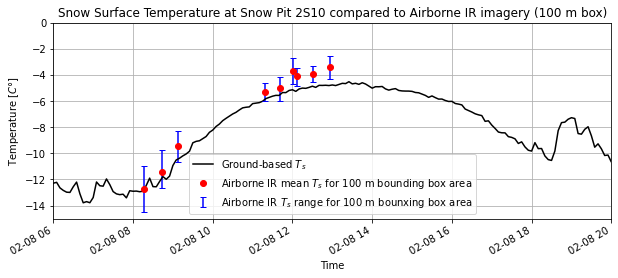

In [249]:
plt.figure(figsize=(10,4))

# plot radiometer average temperature
df.rad_avg.plot(linestyle='-', marker='', markersize=1, c='k', label='Ground-based $T_s$')

# plot the mean airborne IR temperature from the area around the snow pit:
plt.plot(air_timestamps[1], da_clipped.isel(time = 1).mean(),
         marker='o', c='r', linestyle='none',
         label='Airborne IR mean $T_s$ for 100 m bounding box area')

# plot an error bar showing the maximum and minimum airborne IR temperature around the snow pit
plt.errorbar(air_timestamps[1], da_clipped.isel(time = 1).mean(),
            yerr=[[da_clipped.isel(time = 1).mean()-da_clipped.isel(time = 1).min()], 
                  [da_clipped.isel(time = 1).max()-da_clipped.isel(time = 1).mean()]],
            capsize=3, fmt='none', ecolor='b',
            label='Airborne IR $T_s$ range for 100 m bounxing box area')
        
for i in ints:

# plot the mean airborne IR temperature from the area around the snow pit:
    plt.plot(air_timestamps[i], da_clipped.isel(time = i).mean(),
         marker='o', c='r', linestyle='none') #,
        # label='Airborne IR mean $T_s$ for 100 m radius area')

    # plot an error bar showing the maximum and minimum airborne IR temperature around the snow pit
    plt.errorbar(air_timestamps[i], da_clipped.isel(time = i).mean(),
            yerr=[[da_clipped.isel(time = i).mean()-da_clipped.isel(time = i).min()], 
                  [da_clipped.isel(time = i).max()-da_clipped.isel(time = i).mean()]],
            capsize=3, fmt='none', ecolor='b')#,
           # label='Airborne IR $T_s$ range for 100 m radius area')

    
# set axes limits
plt.ylim((-15,0))
plt.xlim((pd.Timestamp(2020,2,8,6,0),pd.Timestamp(2020,2,8,20,0))) # zoom in to daytime hours on Feb. 8, 2020

# add a legend to the plot
plt.legend()

# set axes labels
plt.ylabel('Temperature [$C\degree$]')
plt.xlabel('Time')

# add grid lines to the plot
plt.grid('on')

# set the plot title
plt.title('Snow Surface Temperature at Snow Pit 2S10 compared to Airborne IR imagery (100 m box)');

plt.savefig('timeseries.jpg')

### Compare spatial patterns in open and forest

In [10]:
# create new bounding boxes and quickly verify where they have overlapping data. now let's look at 500 m pixels just to make sure we see something

In [236]:
# set up our box bounding coordinates - pit site (verified that it doesnt contain trees)
minx = 742826
miny = 4322439
maxx = 743326
maxy = 4322939

# bounding box in forest for comparison
minx_for = 743926
miny_for = 4322839
maxx_for = 744426
maxy_for = 4323339

In [237]:
# clip
da_clipped = da.rio.clip_box(minx,miny,maxx,maxy)
da_clipped_for = da.rio.clip_box(minx_for,miny_for,maxx_for,maxy_for)
# both cases have cool datasets for i = 1 and i = 16

In [228]:
# for da_clipped_step in da_clipped_for:
  #  fig, ax = plt.subplots()
    
   # da_clipped_step.plot(ax=ax,cmap='magma')

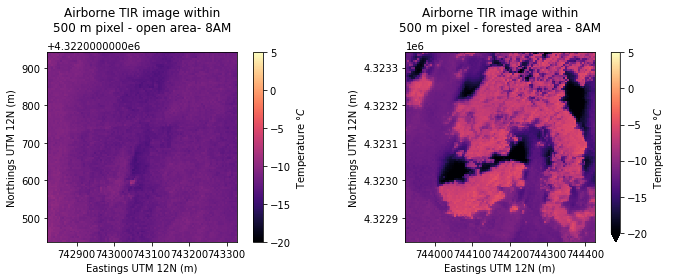

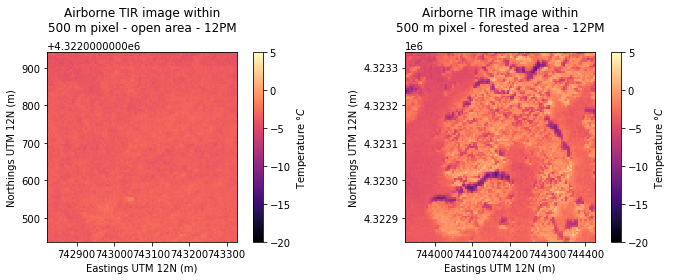

In [244]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4), tight_layout=True)

airborne_ir_area_temperature = da_clipped.isel(time = 1)
# plot the portion of the airborne TIR image we selected within the buffer area geometry
airborne_ir_area_temperature.plot(cmap='magma', vmin=-20, vmax=5, ax=ax[0], 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})
ax[0].set_title('Airborne TIR image within\n500 m pixel - open area- 8AM\n')
ax[0].set_aspect('equal')
ax[0].set_xlabel('Eastings UTM 12N (m)')
ax[0].set_ylabel('Northings UTM 12N (m)')
# ax[0].set_xlim((xmin-150, xmax+150)) # x axis limits to +/- 150 m from our point's "total bounds"
# ax[0].set_ylim((ymin-150, ymax+150)) # y axis limits to +/- 150 m from our point's "total bounds"

airborne_ir_area_temperature = da_clipped_for.isel(time = 1)
# plot the portion of the airborne TIR image we selected within the buffer area geometry
airborne_ir_area_temperature.plot(cmap='magma', vmin=-20, vmax=5, ax=ax[1], 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})
ax[1].set_title('Airborne TIR image within\n500 m pixel - forested area - 8AM\n')
ax[1].set_aspect('equal')
ax[1].set_xlabel('Eastings UTM 12N (m)')
ax[1].set_ylabel('Northings UTM 12N (m)')

plt.savefig('spatial_8am.jpg')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4), tight_layout=True)

airborne_ir_area_temperature = da_clipped.isel(time = 16)
# plot the portion of the airborne TIR image we selected within the buffer area geometry
airborne_ir_area_temperature.plot(cmap='magma', vmin=-20, vmax=5, ax=ax[0], 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})
ax[0].set_title('Airborne TIR image within\n500 m pixel - open area - 12PM\n')
ax[0].set_aspect('equal')
ax[0].set_xlabel('Eastings UTM 12N (m)')
ax[0].set_ylabel('Northings UTM 12N (m)')
# ax[0].set_xlim((xmin-150, xmax+150)) # x axis limits to +/- 150 m from our point's "total bounds"
# ax[0].set_ylim((ymin-150, ymax+150)) # y axis limits to +/- 150 m from our point's "total bounds"

airborne_ir_area_temperature = da_clipped_for.isel(time = 16)
# plot the portion of the airborne TIR image we selected within the buffer area geometry
airborne_ir_area_temperature.plot(cmap='magma', vmin=-20, vmax=5, ax=ax[1], 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})
ax[1].set_title('Airborne TIR image within\n500 m pixel - forested area - 12PM\n')
ax[1].set_aspect('equal')
ax[1].set_xlabel('Eastings UTM 12N (m)')
ax[1].set_ylabel('Northings UTM 12N (m)')

plt.savefig('spatial_12pm.jpg')


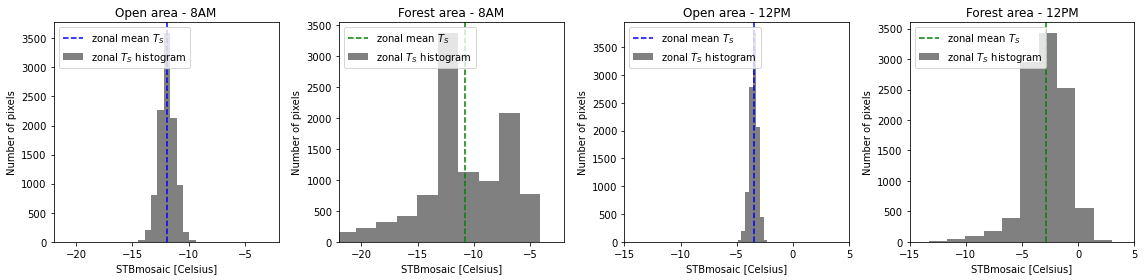

In [245]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4), tight_layout=True)

airborne_ir_area_temperature = da_clipped.isel(time = 1)
# plot a histogram of image temperature data within the buffer area geometry
airborne_ir_area_temperature.plot.hist(ax=ax[0],
                                       color='grey', 
                                       zorder=1, # use zorder to make sure this plots below the point
                                       label='zonal $T_S$ histogram') 

# plot a vertical line for the mean temperature within the buffer area geometry
ax[0].axvline(airborne_ir_area_temperature.mean(), 
              color='b',linestyle='--',  # set color and style
              zorder=2, # use zorder to make sure this plots on top of the histogram
              label='zonal mean $T_S$') 

ax[0].legend(loc='upper left') # add a legend
ax[0].set_xlim((-22,-2)) # set xlim to same values as colorbar in image plot
ax[0].set_title('Open area - 8AM')
ax[0].set_ylabel('Number of pixels');

airborne_ir_area_temperature = da_clipped_for.isel(time = 1)
# plot a histogram of image temperature data within the buffer area geometry
airborne_ir_area_temperature.plot.hist(ax=ax[1],
                                       color='grey', 
                                       zorder=1, # use zorder to make sure this plots below the point
                                       label='zonal $T_S$ histogram') 

# plot a vertical line for the mean temperature within the buffer area geometry
ax[1].axvline(airborne_ir_area_temperature.mean(), 
              color='g',linestyle='--',  # set color and style
              zorder=2, # use zorder to make sure this plots on top of the histogram
              label='zonal mean $T_S$') 

ax[1].legend(loc='upper left') # add a legend
ax[1].set_xlim((-22,-2)) # set xlim to same values as colorbar in image plot
ax[1].set_title('Forest area - 8AM')
ax[1].set_ylabel('Number of pixels');

airborne_ir_area_temperature = da_clipped.isel(time = 16)
# plot a histogram of image temperature data within the buffer area geometry
airborne_ir_area_temperature.plot.hist(ax=ax[2],
                                       color='grey', 
                                       zorder=1, # use zorder to make sure this plots below the point
                                       label='zonal $T_S$ histogram') 

# plot a vertical line for the mean temperature within the buffer area geometry
ax[2].axvline(airborne_ir_area_temperature.mean(), 
              color='b',linestyle='--',  # set color and style
              zorder=2, # use zorder to make sure this plots on top of the histogram
              label='zonal mean $T_S$') 

ax[2].legend(loc='upper left') # add a legend
ax[2].set_xlim((-15,5)) # set xlim to same values as colorbar in image plot
# ax[1].set_ylim((0,400)) # set ylim
ax[2].set_title('Open area - 12PM')
ax[2].set_ylabel('Number of pixels');

airborne_ir_area_temperature = da_clipped_for.isel(time = 16)
# plot a histogram of image temperature data within the buffer area geometry
airborne_ir_area_temperature.plot.hist(ax=ax[3],
                                       color='grey', 
                                       zorder=1, # use zorder to make sure this plots below the point
                                       label='zonal $T_S$ histogram') 

# plot a vertical line for the mean temperature within the buffer area geometry
ax[3].axvline(airborne_ir_area_temperature.mean(), 
              color='g',linestyle='--',  # set color and style
              zorder=2, # use zorder to make sure this plots on top of the histogram
              label='zonal mean $T_S$') 

ax[3].legend(loc='upper left') # add a legend
ax[3].set_xlim((-15,5)) # set xlim to same values as colorbar in image plot
# ax[1].set_ylim((0,400)) # set ylim
ax[3].set_title('Forest area - 12PM')
ax[3].set_ylabel('Number of pixels');

plt.savefig('histograms.jpg')